In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *





#wmt modes

process_gen_modes=[ "wmt_samples0", "wmt_samples1", "wmt_samples2_1","wmt_samples2_2", "wmt_samples3", "wmt_samples4",]


dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model(process_gen_modes)
examples_df = pd.concat(list(dfs_by_model.values()))





/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']
mode is wmttask_names is ['wmt_14_language_pair_de_en_']


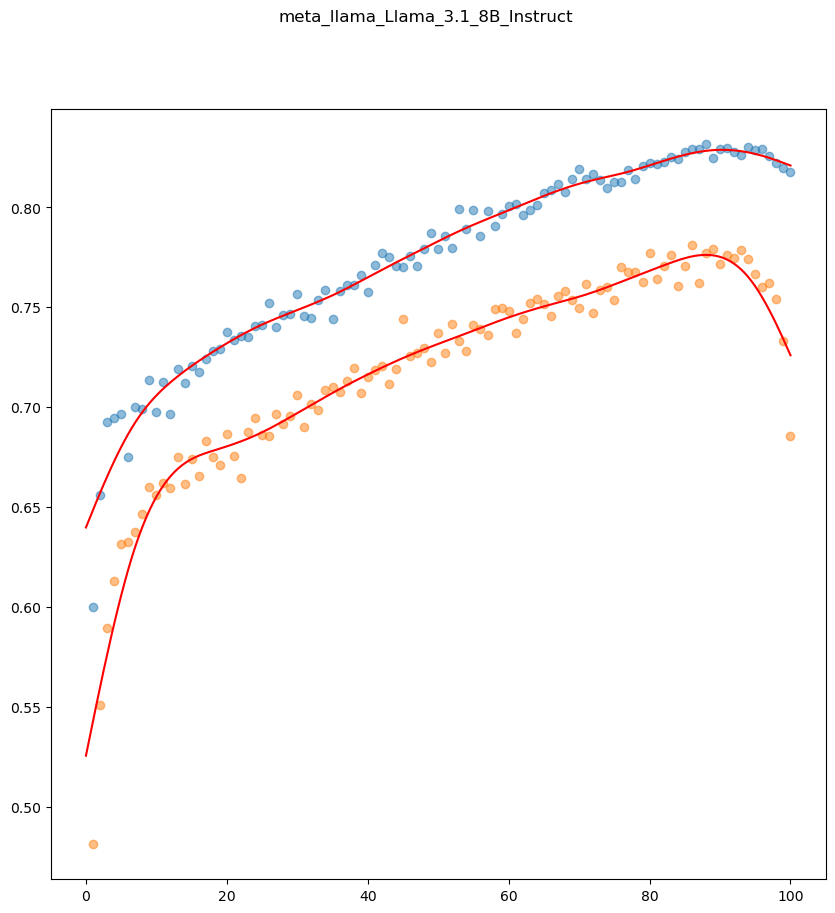

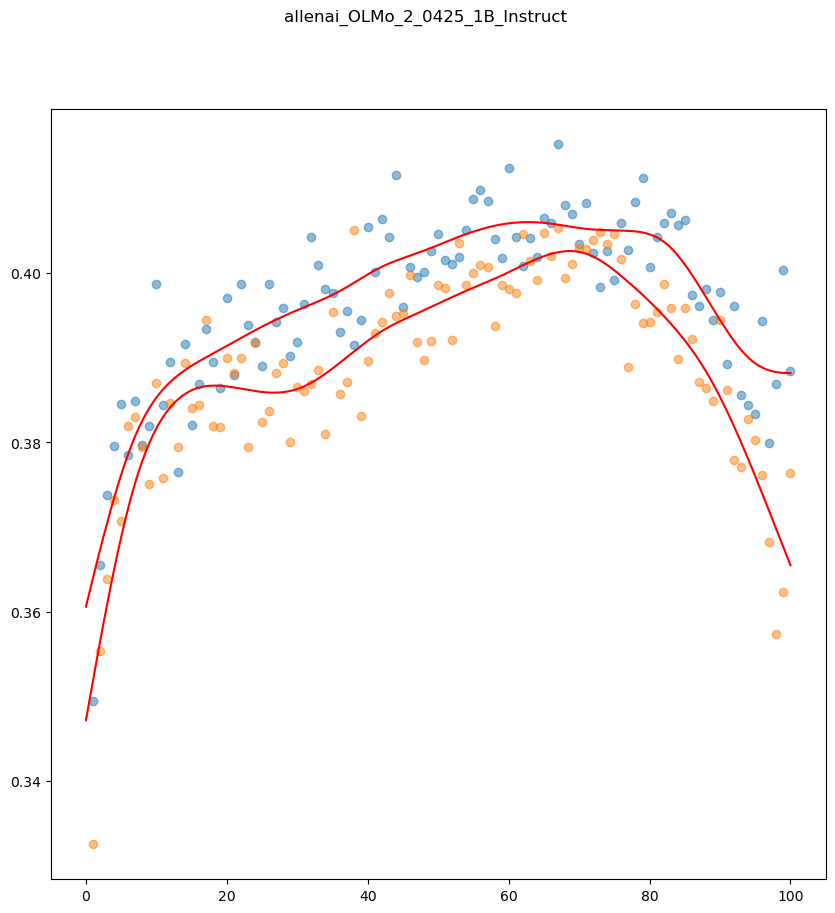

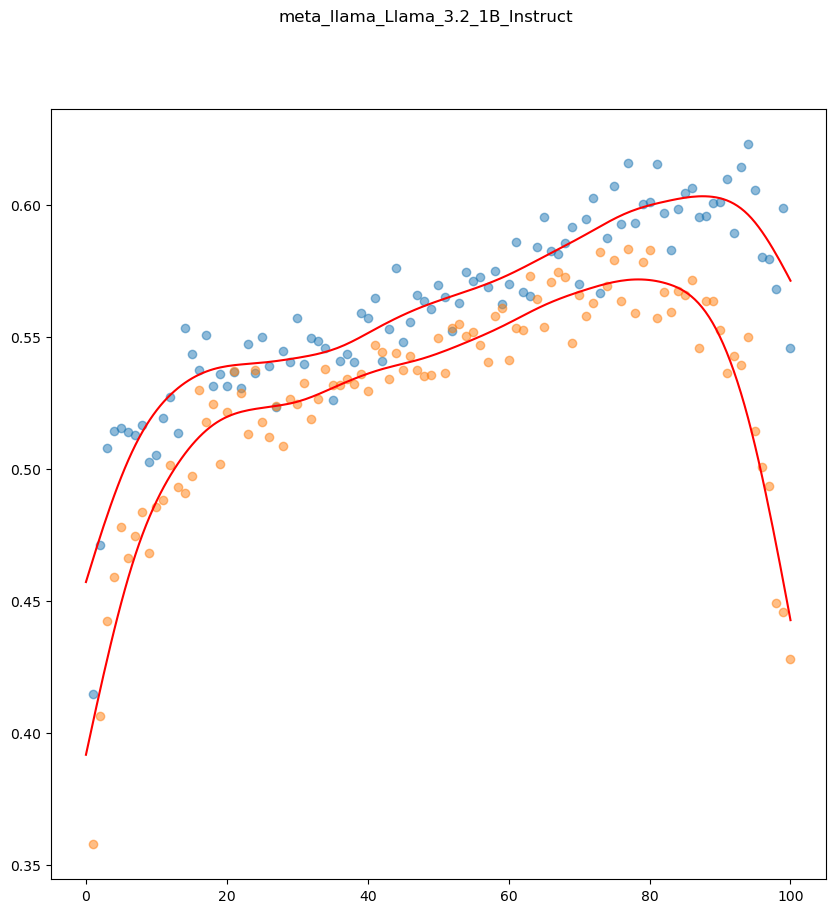

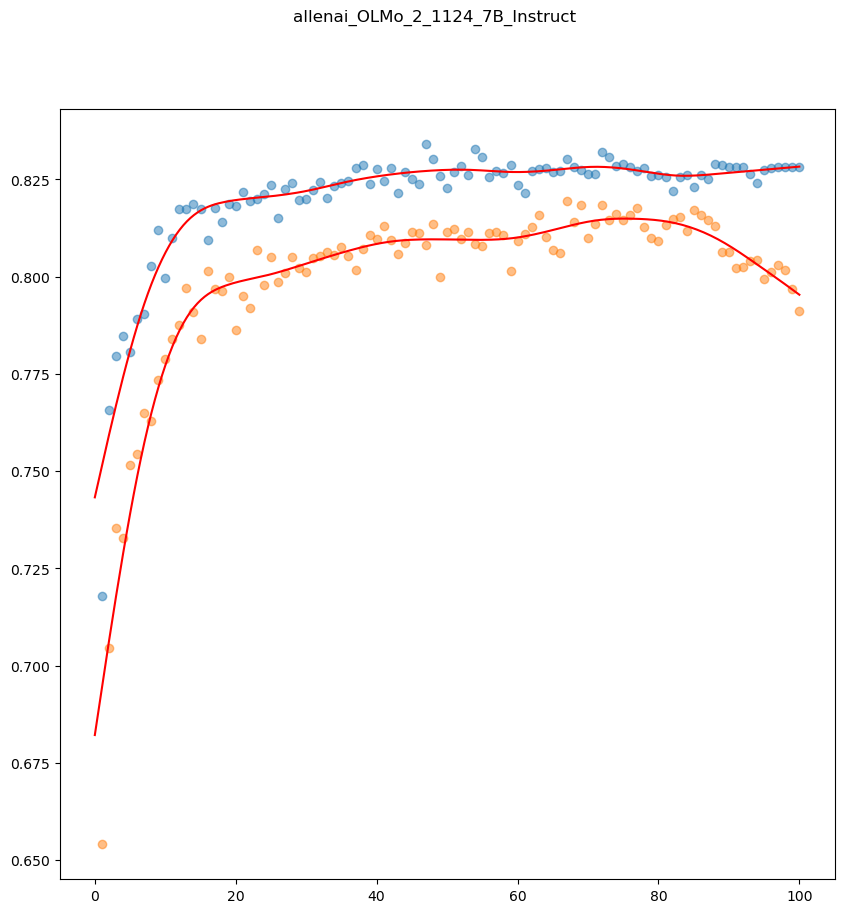

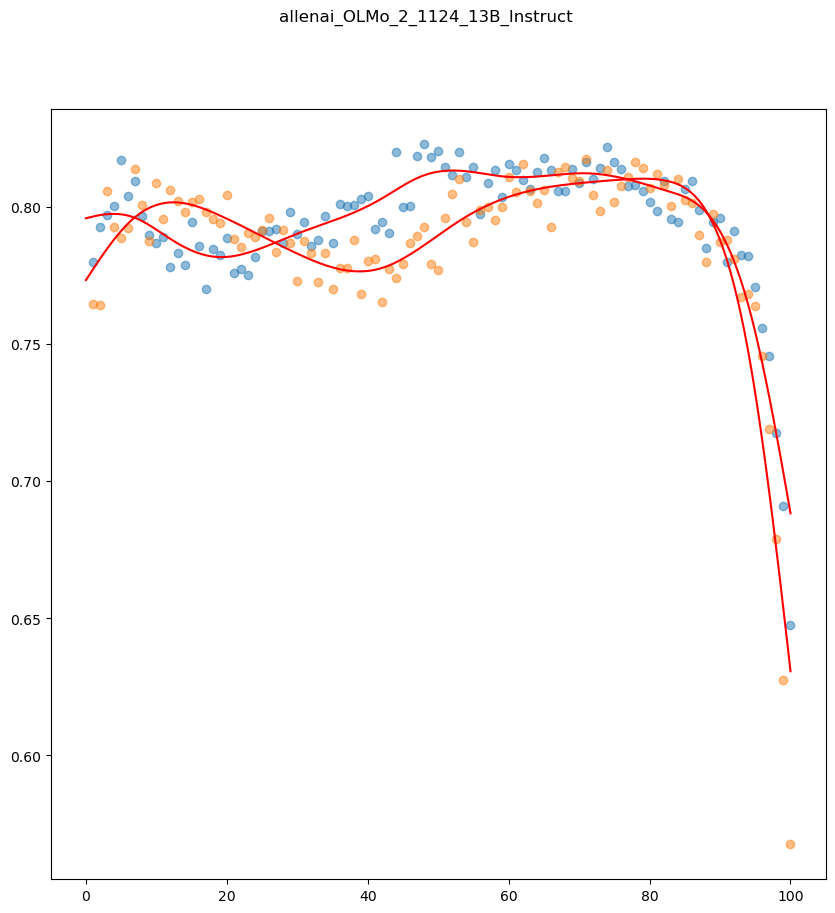

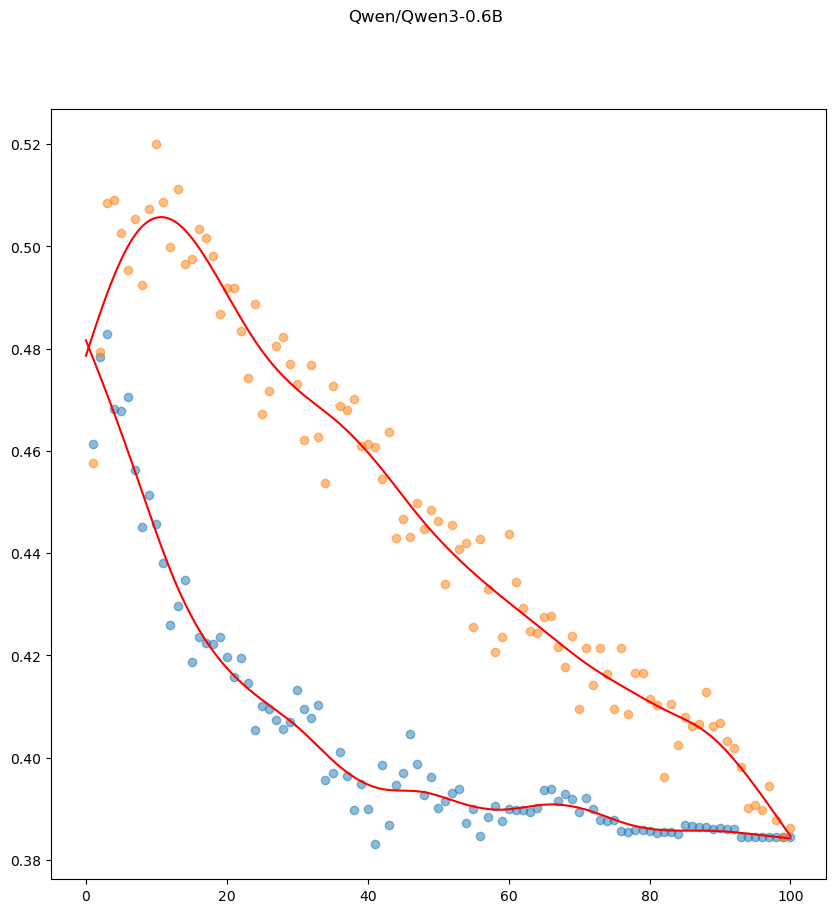

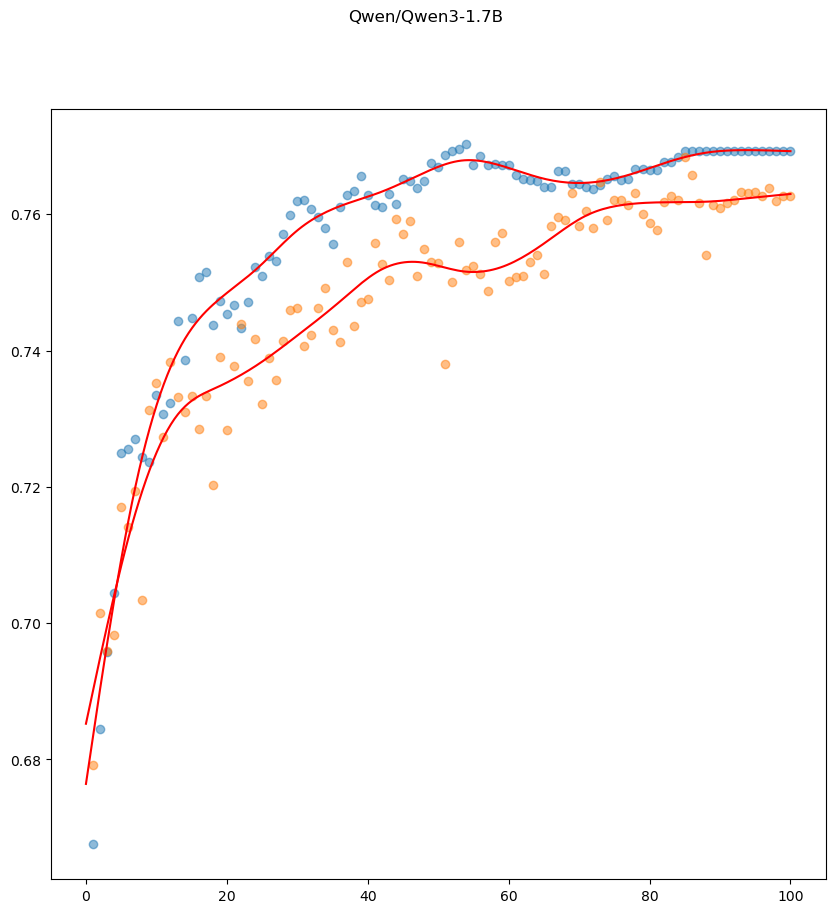

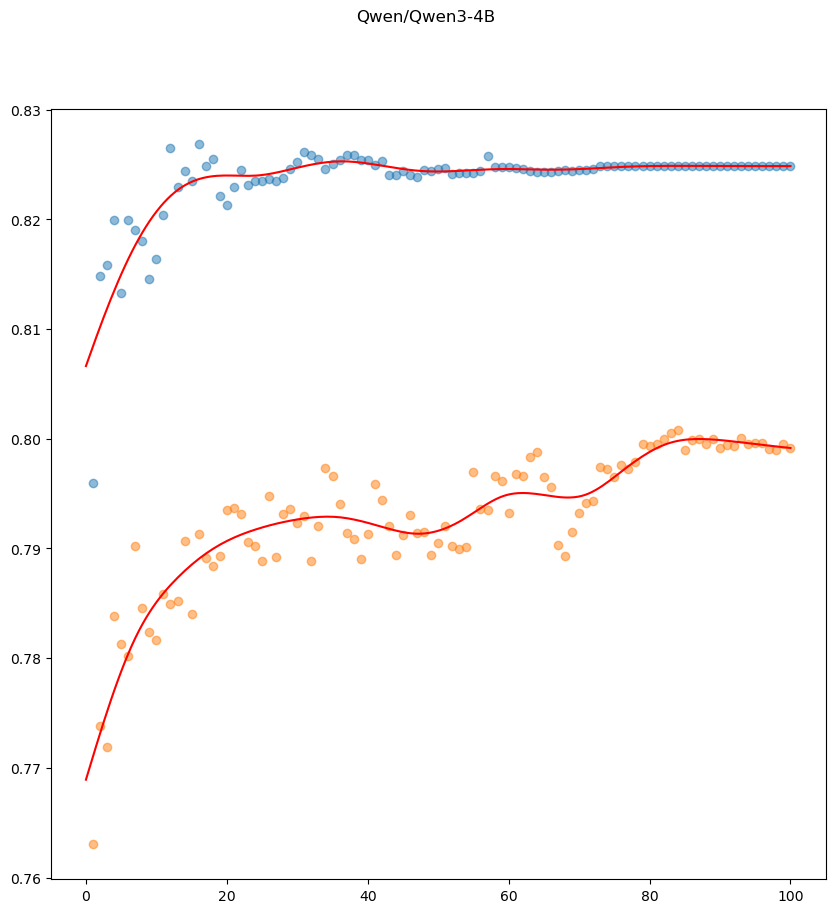

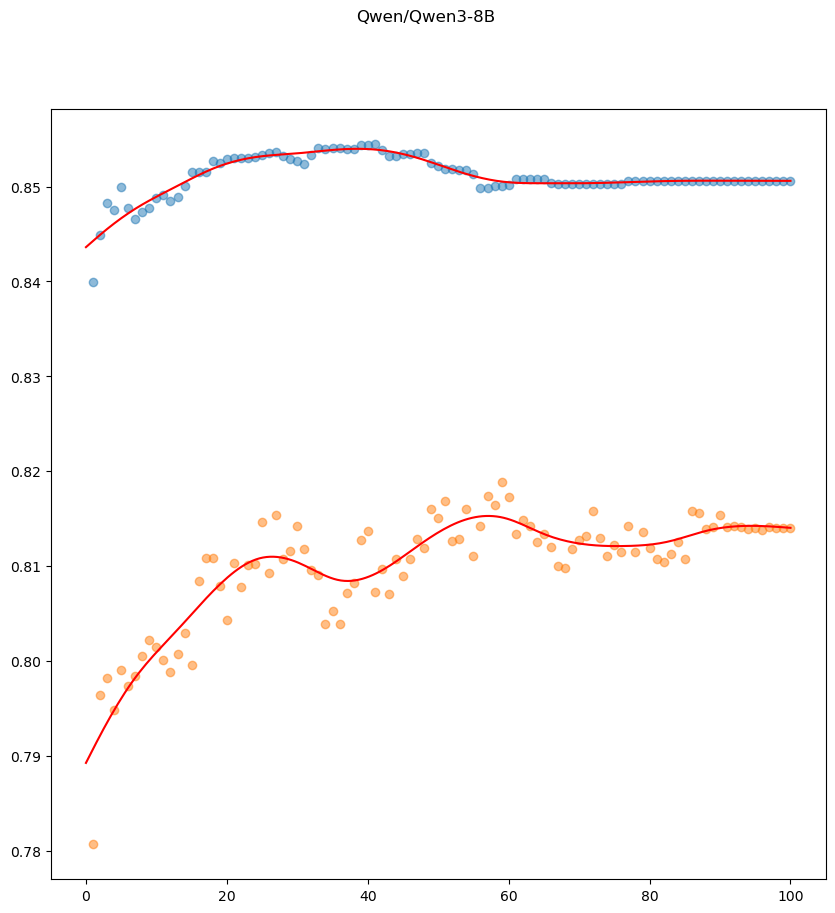

In [17]:

for model, df in dfs_by_model.items():
# df = next(iter(dfs_by_model.values()))
# print(df.head(2))

#ok, first filter for high-entropy sentence
    sentences_df=df[["instanceID","output_logprob"]].groupby("instanceID").mean().reset_index()
    median_logp = sentences_df["output_logprob"].median()
    highp_ids=sentences_df[sentences_df["output_logprob"] >median_logp]["instanceID"]


    cond=df["instanceID"].isin(highp_ids)
    highp_outs=df[cond]
    lowp_outs=df[~cond]

    fig, ax = plt.subplots(figsize=(10,10))
    plot_gam(df=highp_outs, compare_metric=compare_metric, ax=ax)
    plot_gam(df=lowp_outs, compare_metric=compare_metric, ax=ax)
    fig.suptitle(model)



#Ok, we want to plot the gams.

meta_llama_Llama_3.1_8B_Instruct
allenai_OLMo_2_0425_1B_Instruct
meta_llama_Llama_3.2_1B_Instruct
allenai_OLMo_2_1124_7B_Instruct
allenai_OLMo_2_1124_13B_Instruct
Qwen/Qwen3-0.6B
Qwen/Qwen3-1.7B
Qwen/Qwen3-4B
Qwen/Qwen3-8B


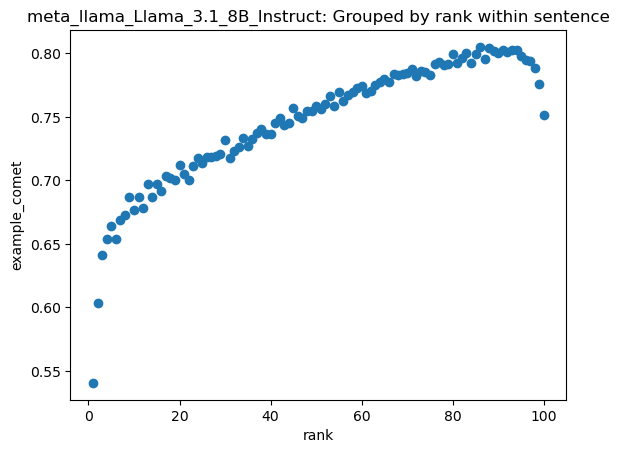

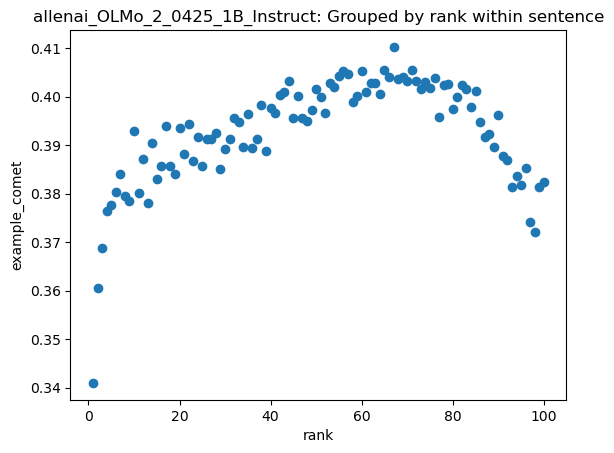

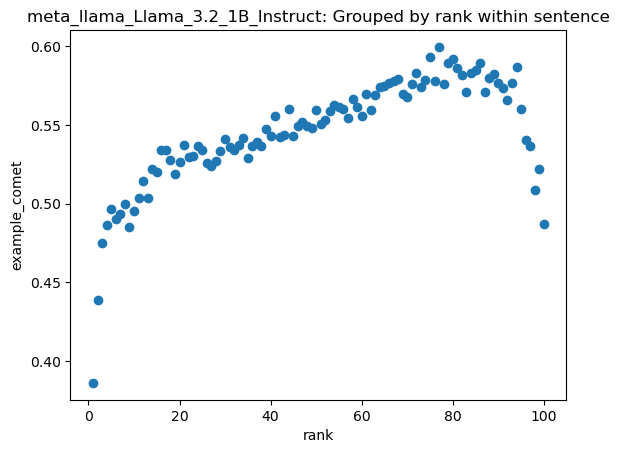

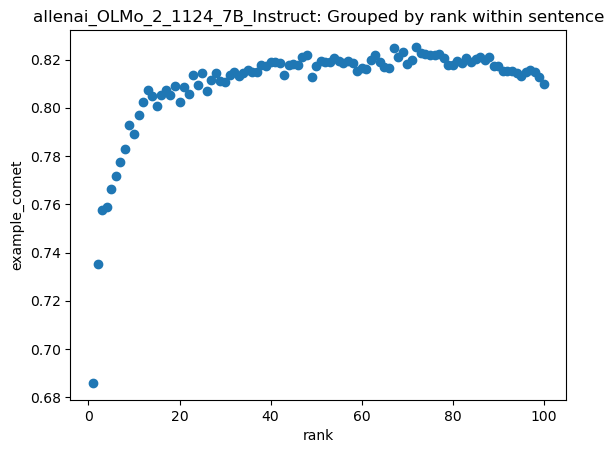

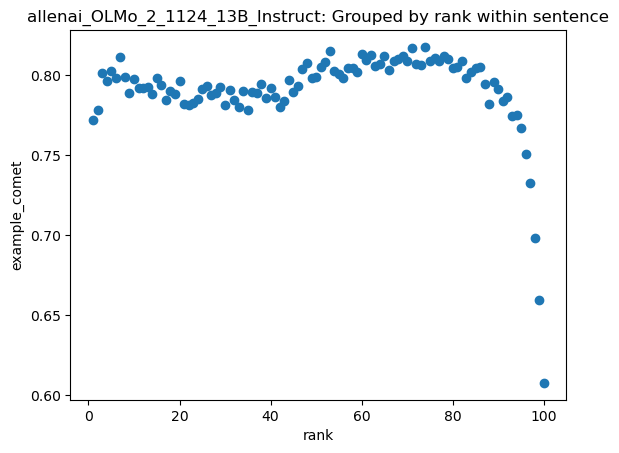

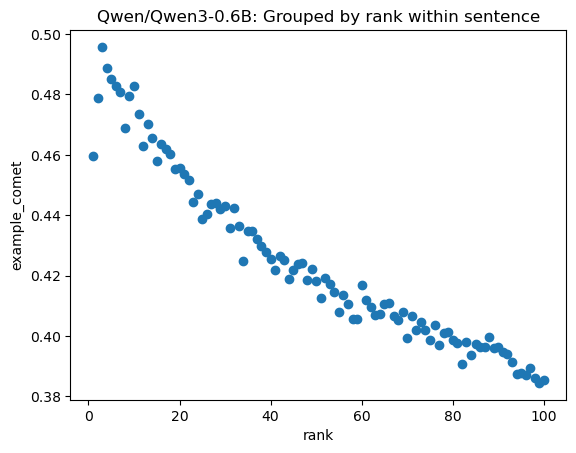

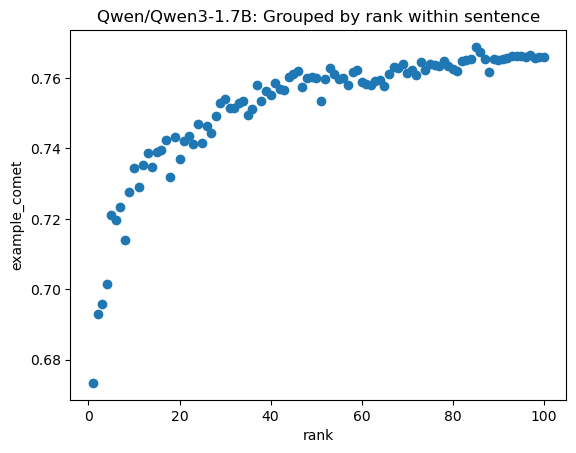

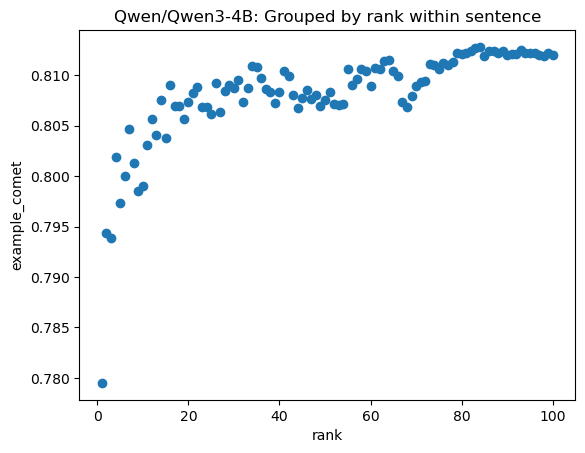

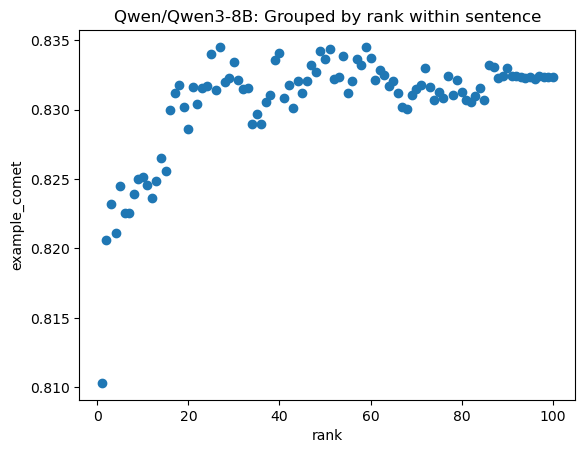

In [3]:

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None


for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs
    

    print(model_name)
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    # plot by rank within sentence
    suptitle="Grouped by rank within sentence"
    # plot_smooth_spline(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax) 
    plot_grouped(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)  

if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    

In [4]:
from process_gen_utils import get_model_details

model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


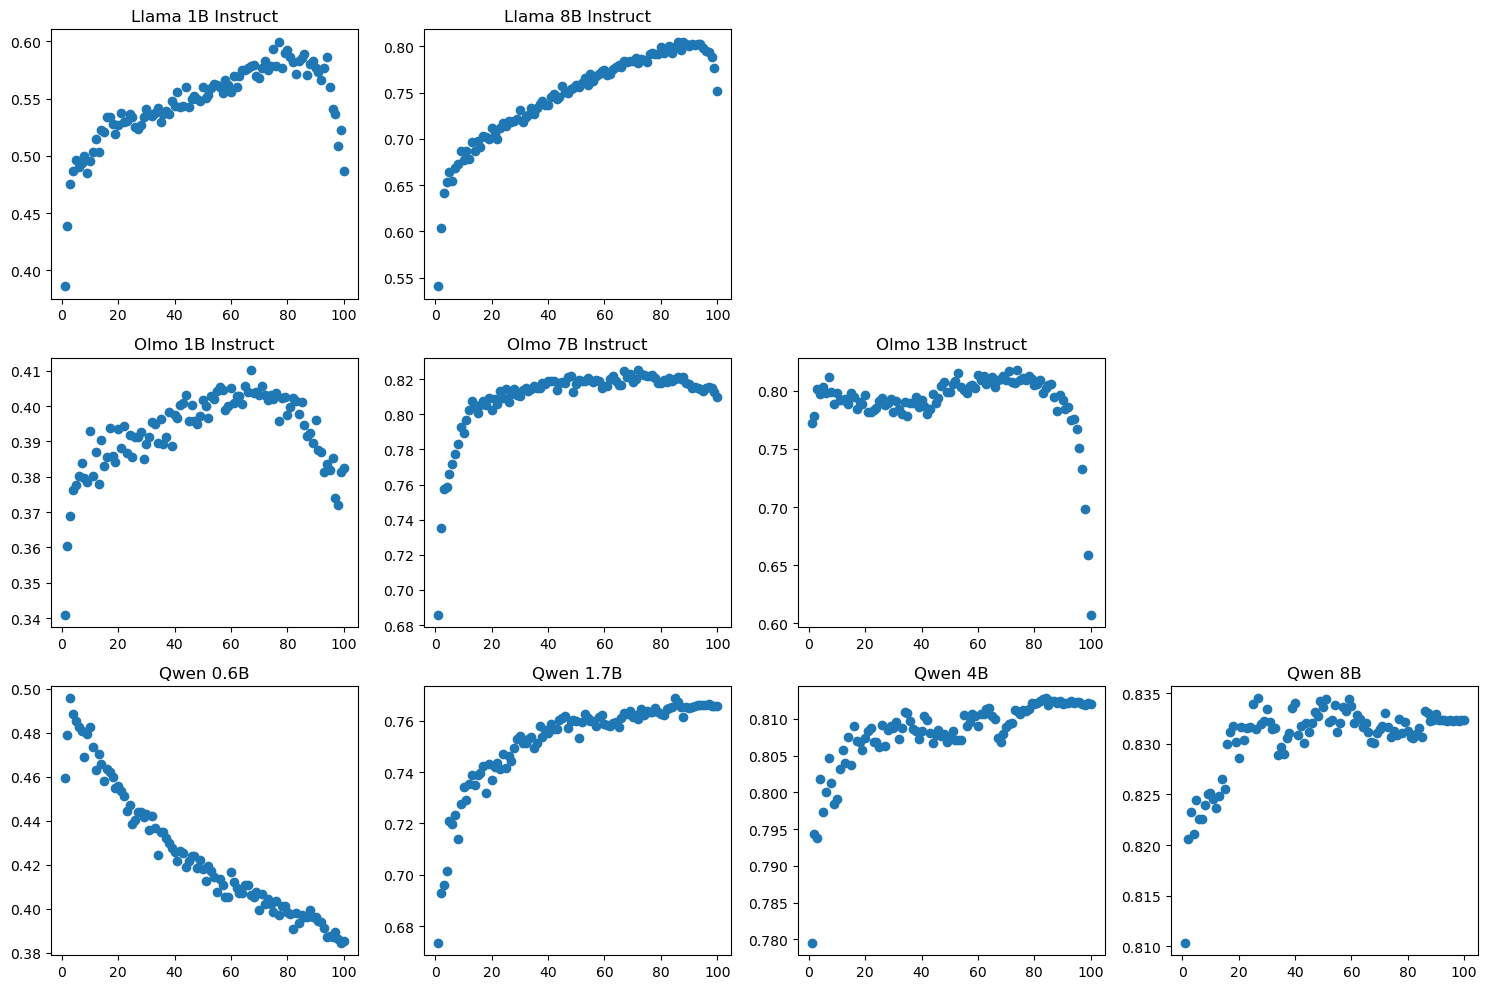

In [5]:

def plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=True, show_labels=False):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        if c>0:
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if error_bar:
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
    return ax




def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"
                ax=plot_grouped(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)  
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()



size_array=[["meta_llama_Llama_3.2_1B_Instruct", "meta_llama_Llama_3.1_8B_Instruct"],
["allenai_OLMo_2_0425_1B_Instruct", "allenai_OLMo_2_1124_7B_Instruct", "allenai_OLMo_2_1124_13B_Instruct"],
["Qwen/Qwen3-0.6B", "Qwen/Qwen3-1.7B","Qwen/Qwen3-4B","Qwen/Qwen3-8B"]
]



qualitative_plots(size_array)




model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


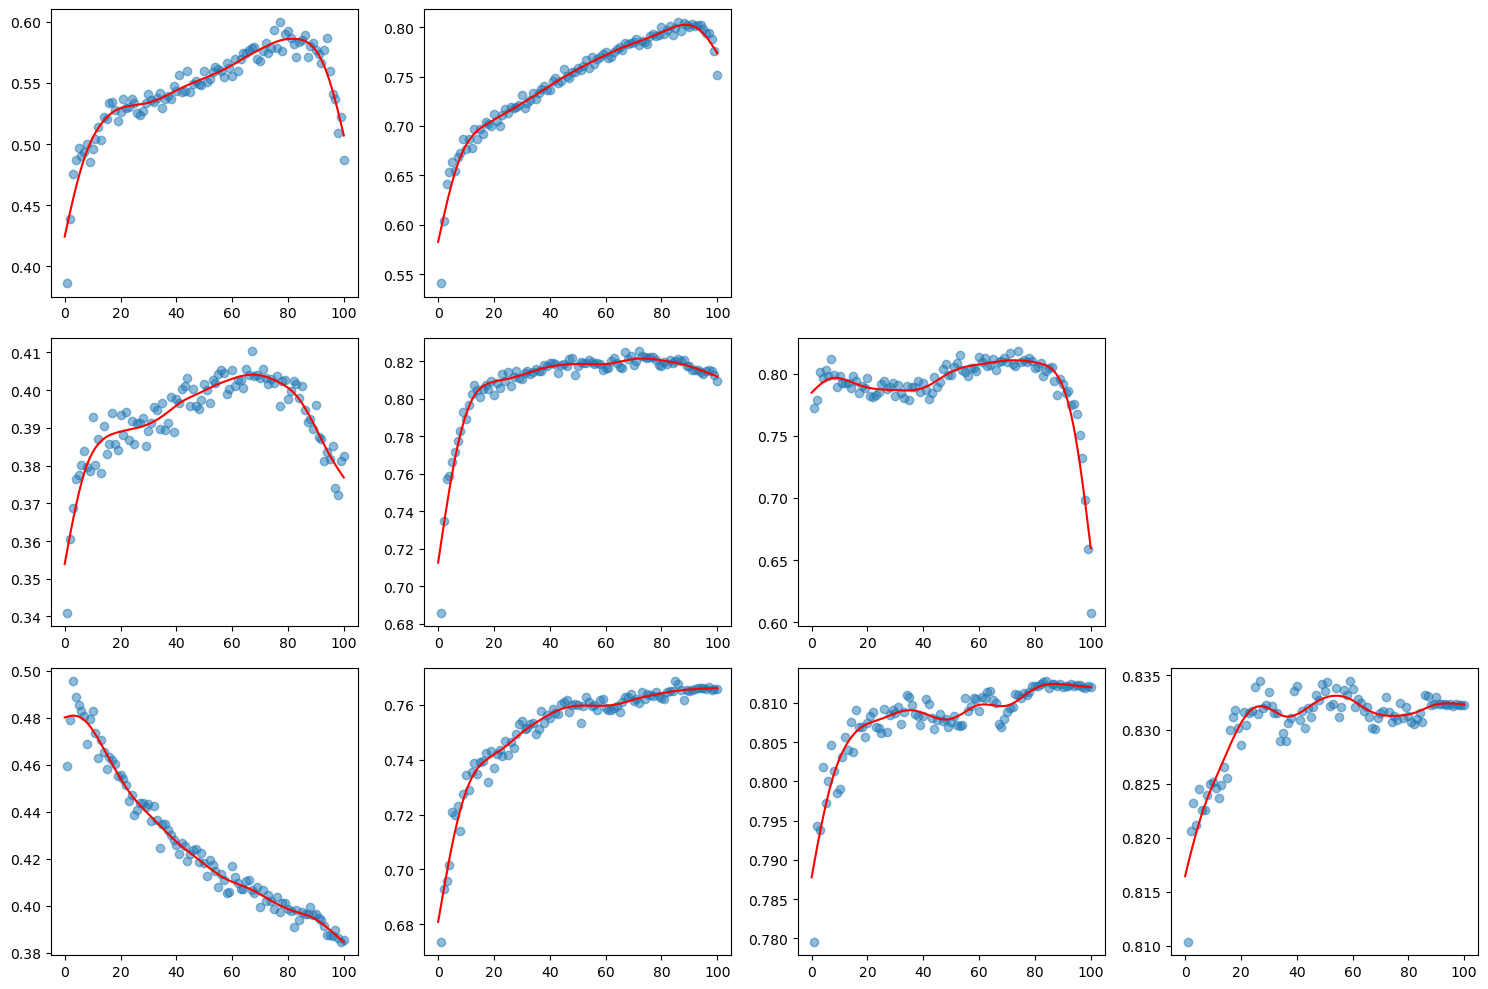

In [6]:
from pygam import LinearGAM, s

def plot_gam(df, compare_metric, ax):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()



    # Assuming df is your dataframe
    X = grouped["rank"].values
    y = grouped[compare_metric].values


    gam = LinearGAM(s(0))

    # Fit the model to the data
    gam.fit(X, y)

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    # Plot the results
    import matplotlib.pyplot as plt


    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    return ax


from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    
    yerr=[]
    if error_bar:
        for i in grouped.index:
            # print(grouped.loc[i][ylabel])
            _, c, s = grouped.loc[i][ylabel]
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), color="red")
    return ax



def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"

                # ax=plot_smooth_spline(filtered_df, xlabel="rank", ylabel=compare_metric, groupby='example_idx', figsize=(10,10), ax=ax)
                ax=plot_gam(df=filtered_df, compare_metric=compare_metric, ax=ax)
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()

qualitative_plots(size_array)


model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


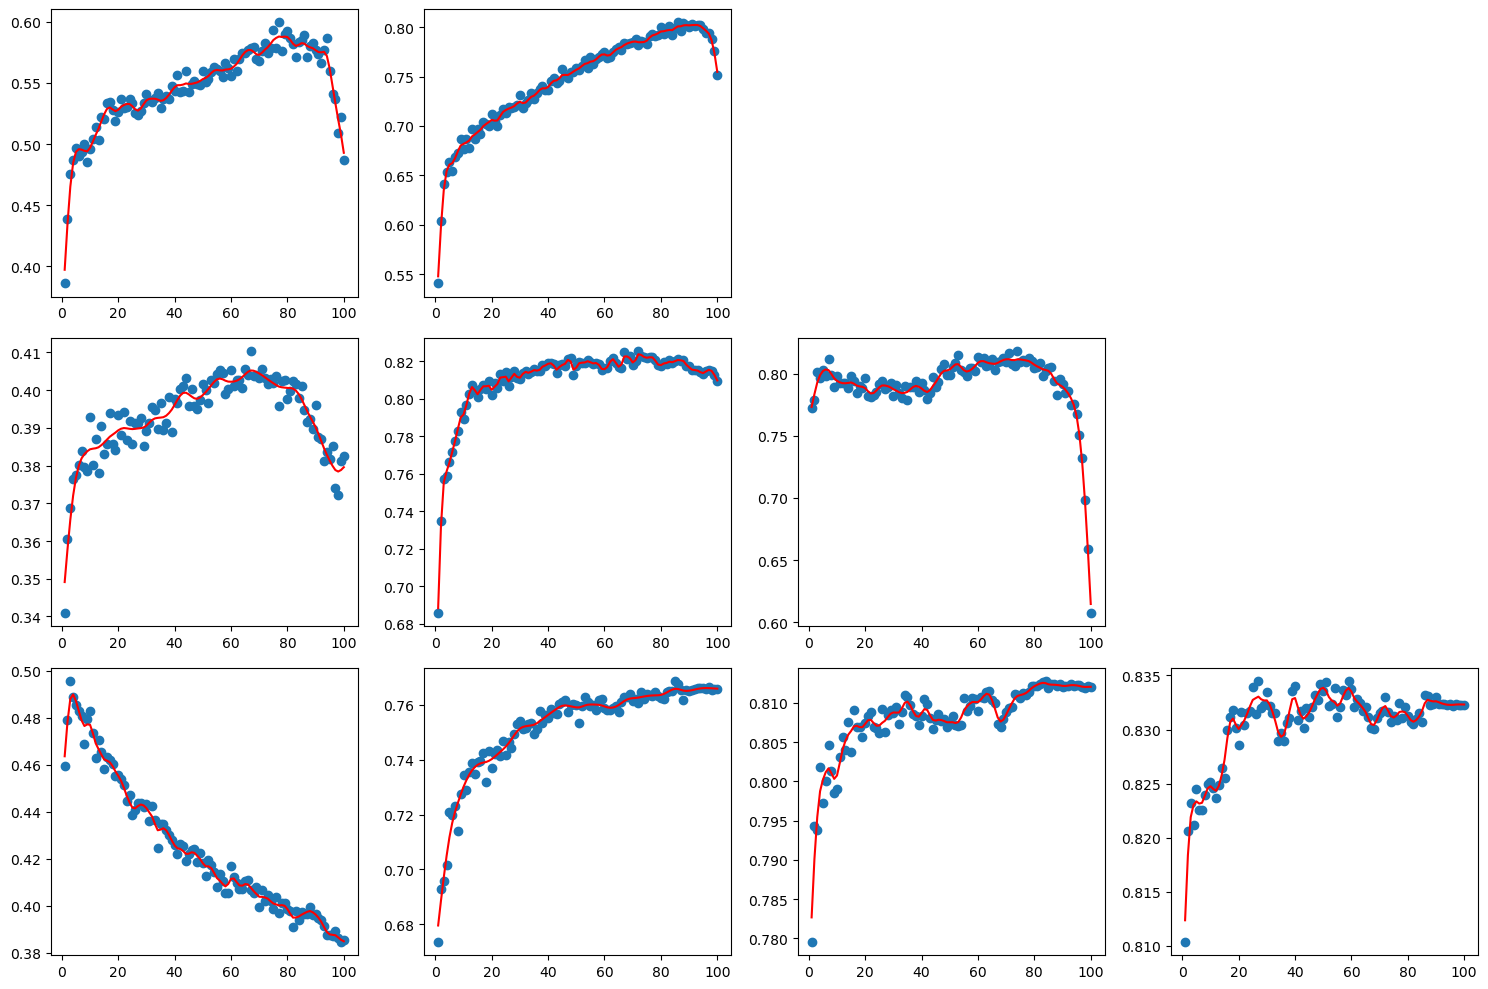

In [7]:
from pygam import LinearGAM, s

def plot_gam(df, compare_metric, ax):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()



    # Assuming df is your dataframe
    X = grouped["rank"].values
    y = grouped[compare_metric].values


    gam = LinearGAM(s(0))

    # Fit the model to the data
    gam.fit(X, y)

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    # Plot the results
    import matplotlib.pyplot as plt


    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    return ax


from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    
    yerr=[]
    if error_bar:
        for i in grouped.index:
            # print(grouped.loc[i][ylabel])
            _, c, s = grouped.loc[i][ylabel]
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), color="red")
    return ax



def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"

                ax=plot_smooth_spline(filtered_df, xlabel="rank", ylabel=compare_metric, groupby='example_idx', figsize=(10,10), ax=ax)
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()

compare_metric="example_comet"
qualitative_plots(size_array)


In [8]:
#ok, here is the plan:
#for each model, calculate the x models
#Calculate the y variables
from calculate_metrics import Calculate_Metrics
x_metrics, y_metrics= Calculate_Metrics(None, None).get_x_y_cols()
print(x_metrics, y_metrics)


all_metrics=[]
for model_name, filtered_df in dfs_by_model.items():
    metrics=Calculate_Metrics(dfs_by_model[model_name], compare_metric).get_best_metrics()
    all_metrics.append(metrics)

metric_df = pd.DataFrame.from_dict(all_metrics)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


['Average Score', 'Entropy', 'Length Bias'] ['PQ Slope', 'PQ Dropoff']


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |#######################

In [9]:
for column in metric_df.columns:

    if pd.api.types.is_numeric_dtype(metric_df[column]):
        print(f"{column} mean is {metric_df[column].mean()}")
#length bias: wrong sign

# For high prob-qual tradeoff, expect: 
# High integral
# High PQ Tradeoff Peak


Average Score mean is 0.6779973126386935
Entropy mean is 42.68008505415227
Length Bias mean is 38.313702236890364
PQ Slope mean is 0.027650189953404406
PQ Dropoff mean is 0.009079317659754085


Index(['Average Score', 'Entropy', 'Length Bias', 'PQ Slope', 'PQ Dropoff',
       'model_name'],
      dtype='object')


<Axes: >

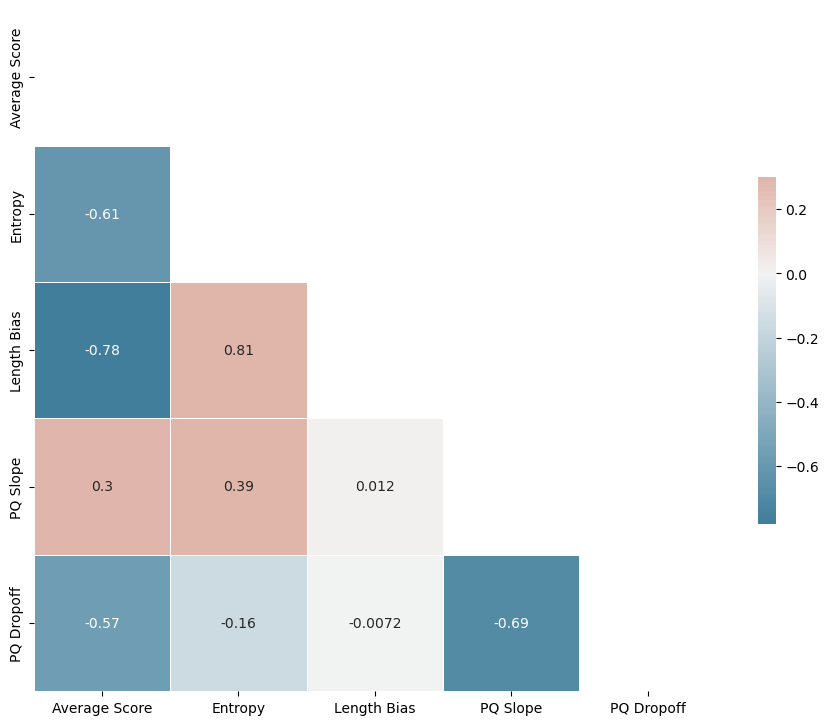

In [10]:
import seaborn as sns

print(metric_df.columns)
corr_df = metric_df.drop("model_name", axis=1)
corr_df= metric_df[['Average Score', 'Entropy', 'Length Bias', 'PQ Slope', 'PQ Dropoff']]
corr = corr_df.corr()
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap')
# plt.show()





# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

#Entrop is negatively correlated with average score, length bias.

#seems to increase PQ effect, linear PQ effect, and tradeoff peak

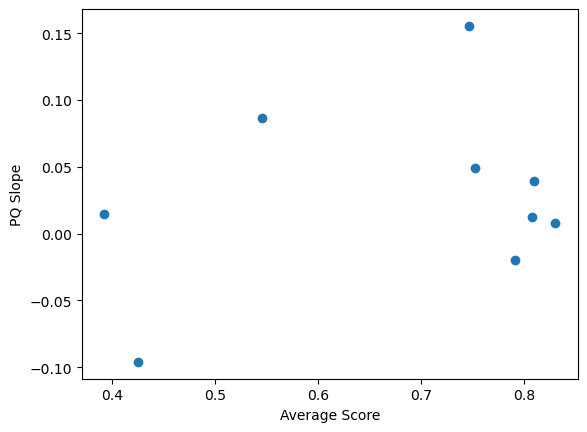

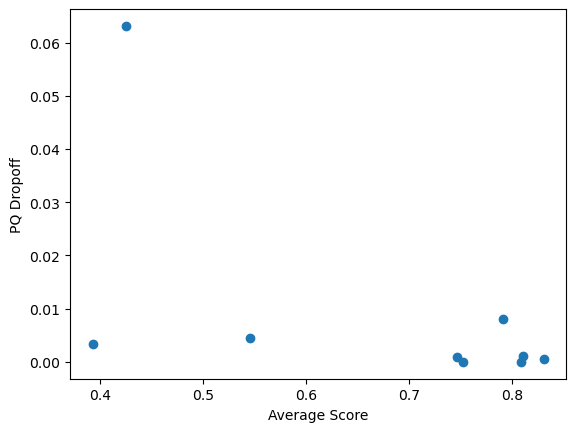

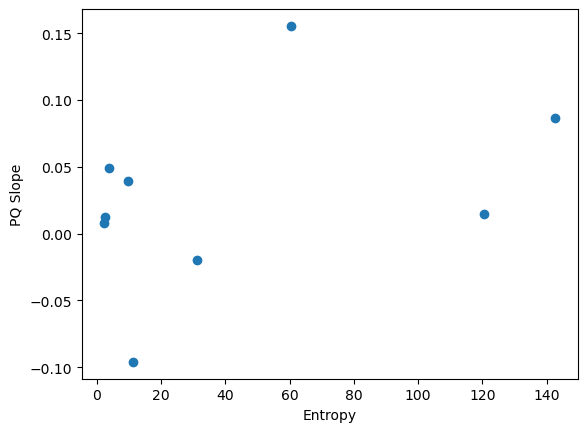

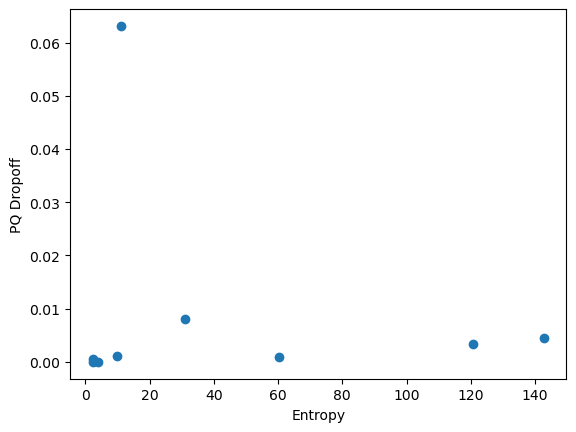

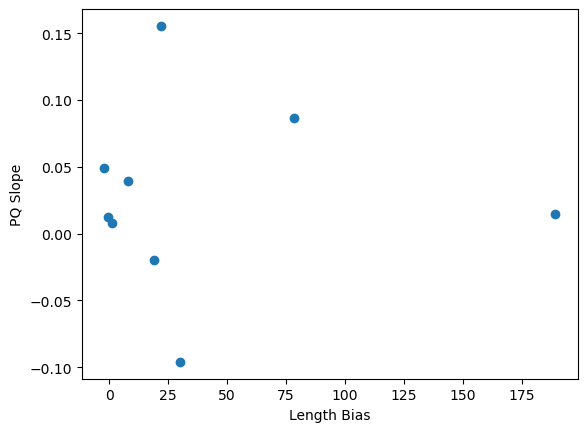

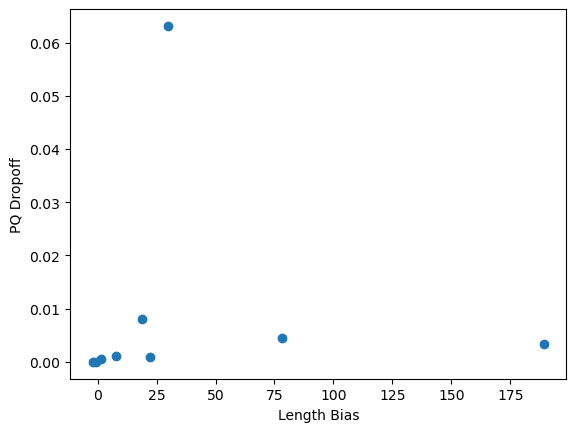

In [11]:
for x_metric in x_metrics:
    for y_metric in y_metrics:
        x=metric_df[x_metric].values
        y=metric_df[y_metric].values

        _, ax = plt.subplots()

        

        ax.scatter(x,y)
        ax.set_xlabel(x_metric)
        ax.set_ylabel(y_metric)


In [12]:


from sklearn.linear_model import LinearRegression

def run_lin_regress(raw_df, x_metrics, y_metrics, normalize_cols=False):
    analysis_df=raw_df.copy()
    if normalize_cols:
        for column in analysis_df.columns:
            if pd.api.types.is_numeric_dtype(analysis_df[column]):
                mean=analysis_df[column].mean()
                stdev = analysis_df[column].std()
                analysis_df[column] = ( analysis_df[column] -mean ) /stdev


    X=analysis_df[x_metrics].values
    for y_metric in y_metrics:
        print(f"\n\n\n\n fitting for {y_metric}")
        y=analysis_df[y_metric].values
        reg = LinearRegression().fit(X, y)
        print(f"score {reg.score(X, y)}")
        print(f"x: {x_metrics}")
        print(f"coeff {reg.coef_}")
        print(f'intercept {reg.intercept_}')


metric_df = pd.DataFrame.from_dict(all_metrics)

print(metric_df.columns)

run_lin_regress(metric_df, x_metrics, y_metrics, normalize_cols=True)




# coeff [-1.45539091 -0.37337658  0.83966912]


Index(['Average Score', 'Entropy', 'Length Bias', 'PQ Slope', 'PQ Dropoff',
       'model_name'],
      dtype='object')




 fitting for PQ Slope
score 0.629062606236712
x: ['Average Score', 'Entropy', 'Length Bias']
coeff [ 0.72760401  1.06722474 -0.2843517 ]
intercept 2.275036216247068e-16




 fitting for PQ Dropoff
score 0.8984407570108557
x: ['Average Score', 'Entropy', 'Length Bias']
coeff [-1.45539091 -0.37337658 -0.83966912]
intercept -3.5085025077017755e-16


WHat factors increase the average difference for gam
Linear bias increases all. Has biggest effect on "gam_ave_diff"


Length_
Ave value decreases gam_diff, iom_est, increases lin_effect 
Seems like probability becomes stronger signal for higher-scoring models

Entropy increases ave_diff, lin_effect, and iom_est

metric_df mean ave_val is 0.6779973126386935
metric_df mean entropy is 42.68008505415227
metric_df mean length_lin_effect is -38.313702236890364


metric_df mean gam_ave_diff is 0.01592187290217585
metric_df mean lin_effect is 0.027650189953404406
metric_df mean iom_est is 0.055050134422080794


In general, entropy is 42


higher ave_diff = more relationship
higher lin_effect = it's more positive between probability and quality
hbigger iom_est = more prominent iom



In [13]:
#ok, plot models based on each of these columns
metric_df.columns
for metric in x_metrics+y_metrics:
    sort_df=metric_df[["model_name", metric]].sort_values(by=metric).reset_index()
    print(f"metric is {metric}")
    print(sort_df.head(9))





metric is Average Score
   index                        model_name  Average Score
0      1   allenai_OLMo_2_0425_1B_Instruct       0.392735
1      5                   Qwen/Qwen3-0.6B       0.424908
2      2  meta_llama_Llama_3.2_1B_Instruct       0.545708
3      0  meta_llama_Llama_3.1_8B_Instruct       0.746246
4      6                   Qwen/Qwen3-1.7B       0.752066
5      4  allenai_OLMo_2_1124_13B_Instruct       0.791260
6      7                     Qwen/Qwen3-4B       0.808205
7      3   allenai_OLMo_2_1124_7B_Instruct       0.810288
8      8                     Qwen/Qwen3-8B       0.830560
metric is Entropy
   index                        model_name     Entropy
0      8                     Qwen/Qwen3-8B    2.313266
1      7                     Qwen/Qwen3-4B    2.428340
2      6                   Qwen/Qwen3-1.7B    3.863338
3      3   allenai_OLMo_2_1124_7B_Instruct    9.728811
4      5                   Qwen/Qwen3-0.6B   11.151894
5      4  allenai_OLMo_2_1124_13B_Instruct   31.